# Adventure Works
## Análise Exploratória

[Rafael Gurgel](https://github.com/rurgel)

### Importação das bibliotecas necessárias

In [32]:
import pandas as pd
from pathlib import Path
from numpy import datetime64
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import itertools

import functions
from config.core import config, DATAPATH

### Obtenção e carregamento da base de dados

O desafio solicita a análise utilizando a biblioteca Pandas.

Entretanto para analisar uma maior quantidade de dados e variáveis, buscou-se a fonte da base original, na Microsoft. Esses dados foram preparados para o uso em um banco SQL. Sendo assim, foi preciso criar um script adicional para carregar os dados no pandas.

Alternativamente, é possível criar uma infraestrutura de banco de dados, carregando um servidor no container e populando o banco de dados. Entretanto isso diverge do objetivo da análise exploratória dos dados. 

<br>
As tabelas serão carregadas separadamente em diferentes variáveis por questões de eficiência de memória. Apenas as informações necessárias serão combinadas ao gerar visualizações.

In [2]:
SalesOrderHeader = functions.get_table('SalesOrderHeader', DATAPATH)
SalesOrderDetail = functions.get_table('SalesOrderDetail', DATAPATH)

Product = functions.get_table('Product', DATAPATH)
ProductSubcategory = functions.get_table('ProductSubcategory', DATAPATH)
ProductCategory = functions.get_table('ProductCategory', DATAPATH)




### Avaliação da consistência da base de dados

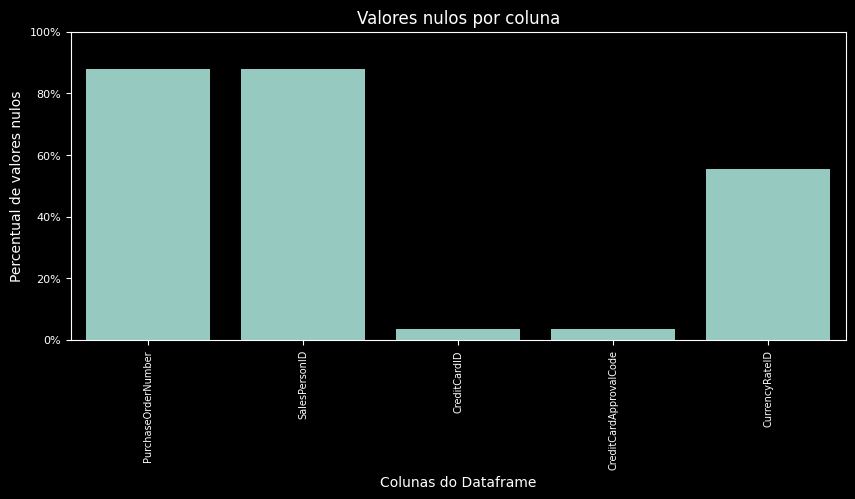

In [3]:
functions.plot_null(SalesOrderHeader, hue=None, filter=True)

Ajustando os tipos de dados. Ao converter o tipo da columna Comment para string, os valores nulos serão preenchidos pela string vazia.

In [4]:
functions.summarize_dtypes(SalesOrderHeader)
functions.summarize_dtypes(SalesOrderDetail)

Tipo dos Dados  Quantidade
         int64           8
        object           6
datetime64[ns]           4
       float64           4
         Int64           3
          bool           1

Tipo dos Dados  Quantidade
         int64           4
       float64           3
        object           2
         Int64           1
datetime64[ns]           1



In [5]:
functions.summarize_dtypes(Product)
functions.summarize_dtypes(ProductCategory)
functions.summarize_dtypes(ProductSubcategory)

Tipo dos Dados  Quantidade
        object          12
         int64           5
       float64           5
         Int64           2
datetime64[ns]           1

Tipo dos Dados  Quantidade
        object           2
         Int64           1
datetime64[ns]           1

Tipo dos Dados  Quantidade
         Int64           2
        object           2
datetime64[ns]           1



### Indicadores básicos

#### Vendas

##### Receitas

In [6]:
functions.show_pandas(
    SalesOrderHeader
        .groupby(pd.Grouper(key='OrderDate', freq='Y'))
        [['SubTotal', 'TaxAmt', 'Freight', 'TotalDue']]
        .sum())

,SubTotal,TaxAmt,Freight,TotalDue
OrderDate,,,,
2011,"$12.641.672,21","$1.153.544,57","$360.482,74","$14.155.699,53"
2012,"$33.524.301,33","$3.162.970,58","$988.428,40","$37.675.700,31"
2013,"$43.622.479,05","$4.071.168,46","$1.272.240,45","$48.965.887,96"
2014,"$20.057.928,81","$1.799.290,84","$562.278,66","$22.419.498,32"


##### Total de pedidos ao longo do tempo

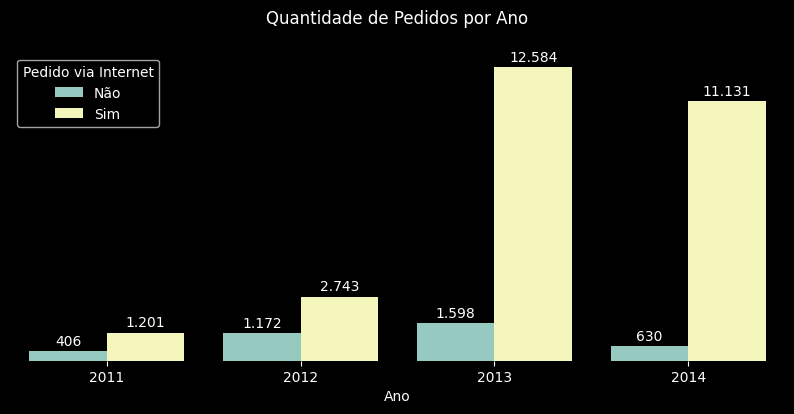

In [84]:
plt.figure(figsize=(10,4))
ax = sns.barplot(data=SalesOrderHeader
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['SalesOrderID']]\
                .count()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='SalesOrderID', hue='OnlineOrderFlag')
ax.set(title='Quantidade de Pedidos por Ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], padding=2)
ax.bar_label(ax.containers[1], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()


##### Total de itens vendidos anualmente

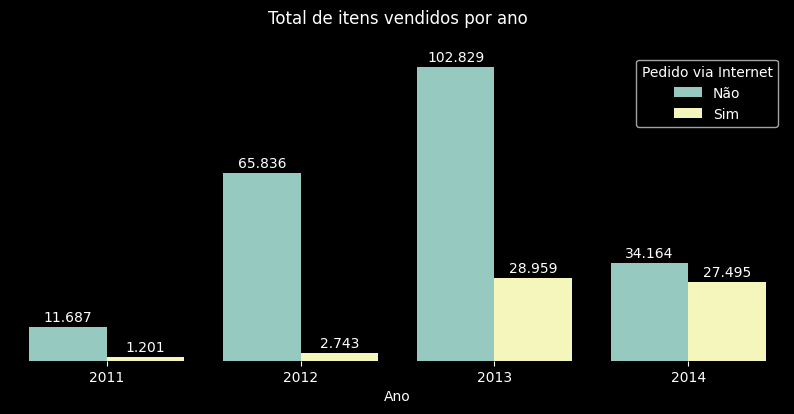

In [83]:
plt.figure(figsize=(10,4))

ax = sns.barplot(data=pd.merge(SalesOrderDetail[['SalesOrderID', 'OrderQty']], 
                               SalesOrderHeader[['SalesOrderID', 'OrderDate', 'OnlineOrderFlag']],
                              on='SalesOrderID', how='left')
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['OrderQty']]\
                .sum()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='OrderQty', hue='OnlineOrderFlag')
ax.set(title='Total de itens vendidos por ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], padding=2)
ax.bar_label(ax.containers[1], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()

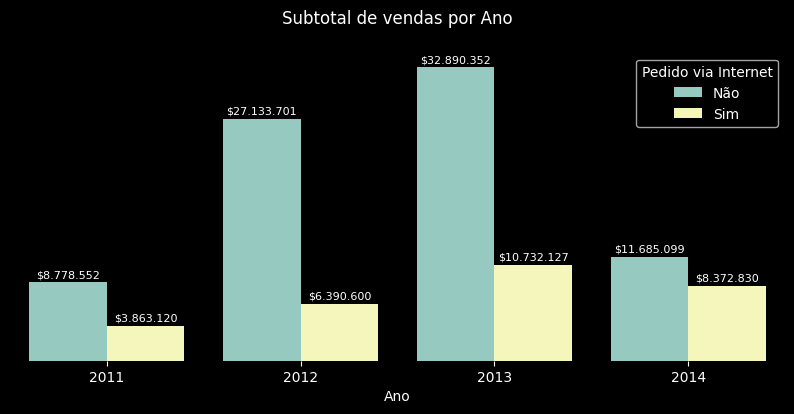

In [85]:
plt.figure(figsize=(10,4))
ax = sns.barplot(data=SalesOrderHeader
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['SubTotal']]\
                .sum()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='SubTotal', hue='OnlineOrderFlag')
ax.set(title='Subtotal de vendas por Ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'${x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], fontsize=8, padding=2)
ax.bar_label(ax.containers[1], labels=[f'${x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], fontsize=8, padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()


#### Portifólio de produtos

##### Categorias de Produtos

In [104]:
SalesOrderDetail[['ProductID', 'OrderQty', 'LineTotal']].set_index('ProductID')\
    .join(Product[['ProductID', 'ProductSubcategoryID']].set_index('ProductID'))\
    .reset_index().set_index('ProductSubcategoryID')\
    .rename(columns={'Name':'ProductName'})\
    .join(ProductSubcategory[['ProductSubcategoryID', 'Name', 'ProductCategoryID']].set_index('ProductSubcategoryID'))\
    .rename(columns={'Name':'Subcategory'})\
    .reset_index(drop=True).set_index('ProductCategoryID')\
    .join(ProductCategory[['ProductCategoryID', 'Name']].set_index('ProductCategoryID'))\
    .rename(columns={'Name':'Category'})\
    .reset_index(drop=True)\
    .groupby(['Category', 'Subcategory'])\
    .agg({'ProductID': 'nunique', 'OrderQty': 'sum', 'LineTotal': 'sum'})\
    .rename(columns={'ProductID': 'Itens Distintos', 
                     'OrderQty': 'Itens Vendidos', 
                     'LineTotal': 'Valor das Vendas'})\
    .style\
    .background_gradient(subset=['Itens Distintos', 'Itens Vendidos'], cmap='PuBu')\
    .format('{0:,.0f}', subset=['Itens Vendidos'], thousands='.', decimal=',')\
    .format('$ {0:,.0f}', subset=['Valor das Vendas'], thousands='.', decimal=',')\
    .bar(subset=['Valor das Vendas'], cmap='YlGn', align='left', width=100, height=60, vmin=0)

#### Produtos mais vendidos

In [109]:
SalesOrderDetail[['ProductID', 'OrderQty', 'LineTotal']].set_index('ProductID')\
    .join(Product[['ProductID', 'Name']].set_index('ProductID'))\
    .rename(columns={'Name': 'Produto'})\
    .groupby('Produto')\
    .sum()\
    .sort_values('OrderQty', ascending=False)\
    .rename(columns={'OrderQty': 'Itens Vendidos', 'LineTotal': 'Valor das Vendas'})\
    .head(10)\
    .style\
        .format('${0:,.0f}', thousands='.', decimal=',', subset='Valor das Vendas')\
        .background_gradient(cmap='Greens', subset=['Valor das Vendas'])\
            .set_table_styles([
                    {'selector': 'th.col_heading',
                     'props': 'font-size: 1.25em;'},
                    {'selector': 'td',
                     'props': 'text-align:center; font-weight:bold;'},
                    {'selector': '.index_name',
                     'props': 'font-style:italic; color:lightgrey; font-weight:normal;font-size:1.2em;'},
                    {'selector': 'th',
                     'props': 'background-color:#1e1f29; color:lightgrey;'},
                    {'selector': 'th:not(.col_heading):not(.index_name)',
                     'props': 'color:white;font-size:1.1em;'},
                ], overwrite=False)

,Itens Vendidos,Valor das Vendas
Produto,,
AWC Logo Cap,8311,$51.229
Water Bottle - 30 oz.,6815,$28.654
"Sport-100 Helmet, Blue",6743,$165.407
"Long-Sleeve Logo Jersey, L",6592,$198.755
"Sport-100 Helmet, Black",6532,$160.870
"Sport-100 Helmet, Red",6266,$157.772
"Classic Vest, S",4247,$156.398
Patch Kit/8 Patches,3865,$8.233
"Short-Sleeve Classic Jersey, XL",3864,$129.146


##### Quais produtos mais comprados em conjunto em uma compra / por cliente

In [241]:
SalesOrderDetail[['SalesOrderID', 'ProductID']]\
    .merge(SalesOrderHeader[['SalesOrderID', 'OnlineOrderFlag']], on='SalesOrderID')\
    .query('OnlineOrderFlag == True')\
    .groupby('SalesOrderID')\
    .agg({'ProductID': lambda x: list(itertools.combinations(x, 2))})\
    .explode(column='ProductID')\
    .reset_index(drop=True)\
    .dropna()\
    .value_counts()\
    .head(10)\
    .reset_index()\
    .explode('ProductID')\
    .rename(columns={0:'Compras'})\
    .reset_index()\
    .merge(Product[['ProductID', 'Name', 'ListPrice']])\
    .sort_values('ListPrice')\
    .groupby('index')\
    .agg(Produto1=('Name', lambda x:x.tail(1)), 
         Produto2=('Name', lambda x:x.head(1)), 
         Compras=('Compras', lambda x: x.head(1)))\
    .style\
    .hide(axis='index')\
    .set_caption('Produtos vendidos em conjunto (Internet)')\
    .set_properties(**{'text-align': 'left'}, subset=['Produto1', 'Produto2'])\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': 'font-size: 1.25em;text-align:left;'},
                       {'selector': 'caption',
                        'props': 'font-size: 1.5em;font-weight: bold;'}
                    ], overwrite=False)

Produto1,Produto2,Compras
Mountain Bottle Cage,Water Bottle - 30 oz.,1267
Road Bottle Cage,Water Bottle - 30 oz.,932
Mountain Tire Tube,Patch Kit/8 Patches,785
Touring Tire,Touring Tire Tube,605
Road Tire Tube,Patch Kit/8 Patches,589
Road Bottle Cage,Water Bottle - 30 oz.,589
HL Mountain Tire,Mountain Tire Tube,556
AWC Logo Cap,Water Bottle - 30 oz.,522
ML Mountain Tire,Mountain Tire Tube,459
"Sport-100 Helmet, Black",Mountain Tire Tube,453


In [240]:
SalesOrderDetail[['SalesOrderID', 'ProductID']]\
    .merge(SalesOrderHeader[['SalesOrderID', 'OnlineOrderFlag']], on='SalesOrderID')\
    .query('OnlineOrderFlag == False')\
    .groupby('SalesOrderID')\
    .agg({'ProductID': lambda x: list(itertools.combinations(x, 2))})\
    .explode(column='ProductID')\
    .reset_index(drop=True)\
    .dropna()\
    .value_counts()\
    .head(10)\
    .reset_index()\
    .explode('ProductID')\
    .rename(columns={0:'Compras'})\
    .reset_index()\
    .merge(Product[['ProductID', 'Name', 'ListPrice']])\
    .sort_values('ListPrice')\
    .groupby('index')\
    .agg(Produto1=('Name', lambda x:x.tail(1)), 
         Produto2=('Name', lambda x:x.head(1)), 
         Compras=('Compras', lambda x: x.head(1)))\
    .style\
    .hide(axis='index')\
    .set_caption('Produtos vendidos em conjunto (Física)')\
    .set_properties(**{'text-align': 'left'}, subset=['Produto1', 'Produto2'])\
    .set_table_styles([{'selector': 'th.col_heading',
                        'props': 'font-size: 1.25em;text-align:left;'},
                       {'selector': 'caption',
                        'props': 'font-size: 1.5em;font-weight: bold;'}
                    ], overwrite=False)

Produto1,Produto2,Compras
"Long-Sleeve Logo Jersey, L",AWC Logo Cap,593
"Long-Sleeve Logo Jersey, L",AWC Logo Cap,501
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Blue",464
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Black",463
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Red",458
"Sport-100 Helmet, Blue","Sport-100 Helmet, Red",448
"Sport-100 Helmet, Black",AWC Logo Cap,440
"Sport-100 Helmet, Blue","Sport-100 Helmet, Black",436
"Sport-100 Helmet, Blue",AWC Logo Cap,432
"Sport-100 Helmet, Red",AWC Logo Cap,425


### Análise dos clientes

#### Tipos de clientes

##### Localização

##### Lucratividade total e média por tipo de cliente

##### Segmento mais requisitado por cada tipo de cliente

##### Forma de pagamento mais utilizada

##### Quantidade de clientes recorrentes

### Insights Estratégicos

#### Relação do perfil demográfico com preferência por produtos vendidos, lucratividade média e total dos grupos, tendência a comprar durante promoções.

#### Influenciadores para compras

#### Efeito dos descontos (por transação e unidades)

#### Taxa de cambio

#### Sazonalidade (% de venda de um produto em relação ao total de vendas foi maior em algum período?)
---- IDEIA: COLORMAP Tipo produto vs mês -> Cor: total de vendas ou % de vendas do produto

#### Relação Tempo Médio de envio x Região x Quantidade de vendas